<a href="https://colab.research.google.com/github/DaniDelgon/Simple_RNN_Stock_Forecast/blob/main/Simple_RNN_Stock_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application of Recurrent Neural Networks (RNN) in the forecasting of Stocks

In this project, the knowledge acquired about RNNs will be applied to train models that are capable of predicting the behaviour of the time series. To do so, a temperature dataset will be used to predict the future values of the time series through the application of RNN. We will see how modelling using RNN is a very good option in these cases of time series.

In [6]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.2


The next step is to import the numpy and matplotlib libraries. In addition, we define the **plot_series** method that will be used to make the time series plots.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

We download the dataset of the prices of the current stock we would like to predict with the help of the library 'yfinance'.

[*********************100%***********************]  1 of 1 completed


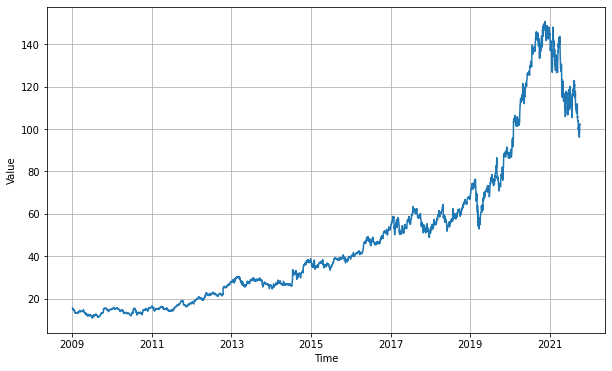

In [55]:
import yfinance as yf

ticker='GOOG'
data=yf.download(ticker,start='2010-01-01')  
data.reset_index(inplace=True)

series = np.array(data['Close'])
time = np.array(data['Date'])
plt.figure(figsize=(10, 6))
plot_series(time, series)

A very common technique when dealing with time series is to use a time window that is shifted over the time series to reduce your analysis to what happens in that window locally, and then perform the global modelling.

In [20]:
## variables para la técnica de la ventana temporal
split_time = 2500
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

## Split del dataset en entrenamiento y validación

## tu código para la creación de las 4 variables del ejercicio 1 aquí

time_train=time[:split_time]
X_train=series[:split_time]

time_valid=time[split_time:]
X_valid=series[split_time:]

In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

Next, using the **windowed_dataset** method as a model, the **model_forecast** method will be adapted and used to predict the next values of the time series using the time window technique.

In [22]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size , shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast=model.predict(ds)
  return forecast

Next, the keras session is cleaned, and the necessary variables are initialised in order to design the time series model to be trained using RNN.

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

In [24]:
train_set=windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)

Now, it's time to design a Recurrent Neural Network (RNN) with LSTM layers (Long-Short Term Memory) which will help us in the handling of the time series data.

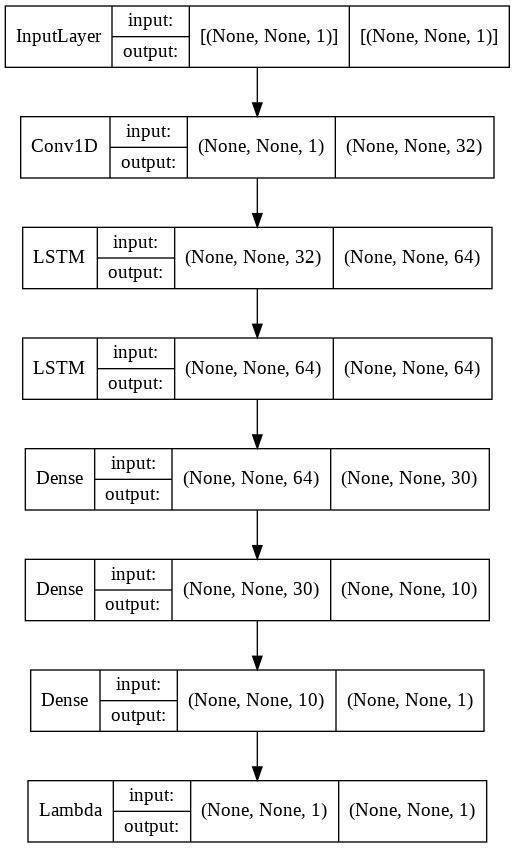

In [66]:
import keras
import tensorflow as tf

model=keras.models.Sequential()

model.add(keras.layers.Conv1D(32,5,strides=1,padding='causal',activation='relu',input_shape=(None,1)))
model.add(keras.layers.LSTM(64,return_sequences=True))
model.add(keras.layers.LSTM(64,return_sequences=True))   

model.add(keras.layers.Dense(30))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(1))
model.add(keras.layers.Lambda(lambda x: x * 400))

keras.utils.vis_utils.plot_model(model, show_shapes=True, show_layer_names=False)

We are going to design a callbacks method for the learning rate that will be stored in the **lr_schedule** variable, this method should use the **LearningRateScheduler** method of Python and will be a **lambda** function that will give the value to epoch of 1e-8 * 10**(epoch / 20). 

In [27]:
def scheduler(epoch):
  x=lambda y: 1e-8 * 10 **(y / 20)
  return x(epoch)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

Now, we compile our model with the loss, the optimizer and the metrics we'll choose to use. We want to use the optimizer combined with the learning reate scheduler we just created in the coding cell above.

In [28]:
model.compile(loss=keras.losses.Huber(),optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9),metrics=['mae'])

Then, it's time to train our model and display the optimal learning rate of the training.

In [29]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 8s 304ms/step - loss: 85.3691 - mae: 85.8691 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 3s 298ms/step - loss: 74.1715 - mae: 74.6715 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 3s 292ms/step - loss: 58.8466 - mae: 59.3451 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 3s 294ms/step - loss: 45.8365 - mae: 46.3327 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 3s 293ms/step - loss: 39.6361 - mae: 40.1340 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 3s 294ms/step - loss: 36.7584 - mae: 37.2566 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 3s 294ms/step - loss: 34.9449 - mae: 35.4429 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 3s 298ms/step - loss: 33.3710 - mae: 33.8692 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 3s 298ms/step - loss: 31.78

Displaying of the optimal learning rate for this training.

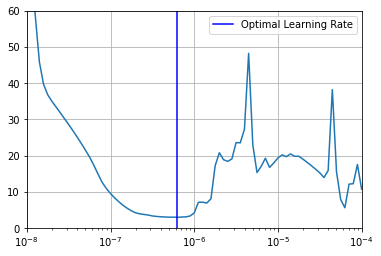

In [40]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

loss_min=np.min(history.history["loss"])
min_coord=np.where(history.history["loss"]==loss_min)[0][0]
lr_min=history.history["lr"][min_coord]
plt.axvline(x = lr_min, color = 'b', label = 'Optimal Learning Rate')

plt.legend()
plt.grid()
plt.show()

The training session and the train_set variable are re-initialised:

In [41]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

To create the new model, reuse the neural network designed previously, but this time using 60 filters in the convolution layer, significantly more than the previous model.

In [42]:
model=keras.models.Sequential()

model.add(keras.layers.Conv1D(60,5,strides=1,padding='causal',activation='relu',input_shape=(None,1)))
model.add(keras.layers.LSTM(64,return_sequences=True))
model.add(keras.layers.LSTM(64,return_sequences=True))
model.add(keras.layers.Dense(30))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(1))
model.add(keras.layers.Lambda(lambda x: x * 400))

The model then compiles itself with the same parameters as the previous compilation, but this time using the optimal learning rate reached before.

In [43]:
model.compile(loss=keras.losses.Huber(),optimizer=tf.keras.optimizers.SGD(learning_rate=lr_min,momentum=0.9),metrics=['mae'])

Training of the model.

In [44]:
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 9s 129ms/step - loss: 36.1127 - mae: 36.6092
Epoch 2/150
25/25 [==============================] - 3s 127ms/step - loss: 7.6493 - mae: 8.1358
Epoch 3/150
25/25 [==============================] - 7s 249ms/step - loss: 4.0062 - mae: 4.4792
Epoch 4/150
25/25 [==============================] - 3s 126ms/step - loss: 2.5831 - mae: 3.0366
Epoch 5/150
25/25 [==============================] - 3s 126ms/step - loss: 2.0408 - mae: 2.4811
Epoch 6/150
25/25 [==============================] - 3s 125ms/step - loss: 1.9206 - mae: 2.3593
Epoch 7/150
25/25 [==============================] - 3s 125ms/step - loss: 1.7494 - mae: 2.1937
Epoch 8/150
25/25 [==============================] - 3s 124ms/step - loss: 1.6135 - mae: 2.0548
Epoch 9/150
25/25 [==============================] - 3s 126ms/step - loss: 1.6851 - mae: 2.1272
Epoch 10/150
25/25 [==============================] - 3s 126ms/step - loss: 1.3688 - mae: 1.8013
Epoch 11/150
25/25 [=================

To conclude this miniproject, the model_forecast method that has been designed using the time window method is used to make the new rnn_forecast method to calculate the new values of the time series. Subsequently, a graph is painted to view these results and visually check that they are correct. In addition, the results of these predictions are given in numerical form, so that the model designed in this activity could be the input for a new algorithm if necessary.

In [45]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

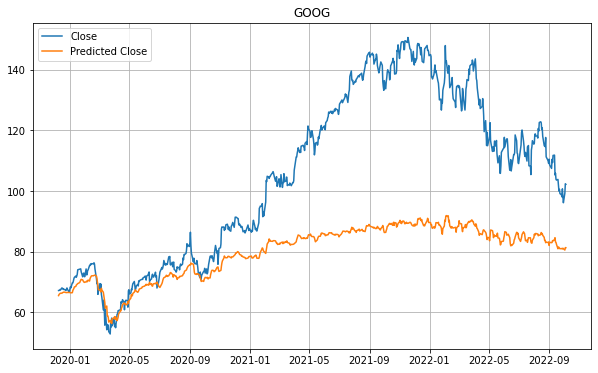

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, X_valid,label='Close')
plt.plot(time_valid, rnn_forecast,label='Predicted Close')

plt.title(ticker)
plt.legend()
plt.grid()
plt.show()

We can see that as we move further from the initial point of the graph, the error of the prediction is bigger, so we make a zoom in the first days of this prediction.

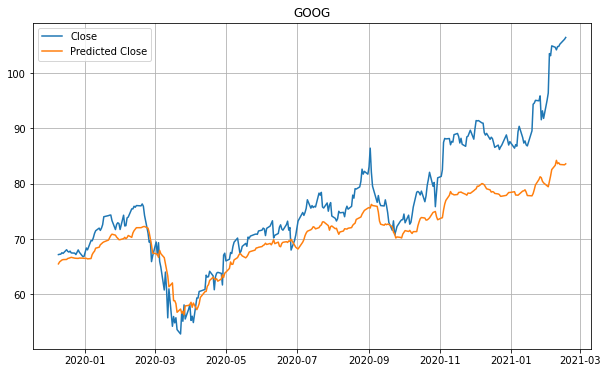

In [63]:
days=300

plt.figure(figsize=(10, 6))
plt.plot(time_valid[0:days], X_valid[0:days],label='Close')
plt.plot(time_valid[0:days], rnn_forecast[0:days],label='Predicted Close')

plt.title(ticker)
plt.legend()
plt.grid()
plt.show()

We can see that our model have learning some patterns of this stock and have some acceptable just by training it with the closes prices of the stock we are studying. But we can further improve this forecasting with some finance feature engineering, by training this model with candle data, MACD... instead of solely training it with the close price, but as a proof of concept, the results just with the Close prices are acceptable.